# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [66]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

In [67]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px

In [68]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Dataset loading


In [69]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-11-26 16:28:43--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.227.232, 54.231.196.48, 52.216.109.69, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.227.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  54.1MB/s    in 0.2s    

2023-11-26 16:28:43 (54.1 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [70]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [71]:
from clearml import Task

config = {
    'web_server': 'https://app.clear.ml',
    'api_server': 'https://api.clear.ml',
    'files_server': 'https://files.clear.ml',
    'credentials': {
        'access_key': 'T71V9W8MGX1CNKBCVCTD',
        'secret_key': 'NCX1LdL1MYEbXCFAXPBAcDjDCx5eWr3XdzgomsaUBsfmtIDMzi'
    },
    'project_name': 'Deep Neural Networks',
    'task_name': 'Homework 1'
}

Task.set_credentials(web_host=config['web_server'],
                     api_host=config['api_server'],
                     files_host=config['files_server'],
                     key=config['credentials']['access_key'],
                     secret=config['credentials']['secret_key'])

task = Task.create(project_name=config['project_name'], task_name=config['task_name'])
task.mark_started()

logger = task.get_logger()

# Network definition (as in laboratory 3)


In [72]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))

# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


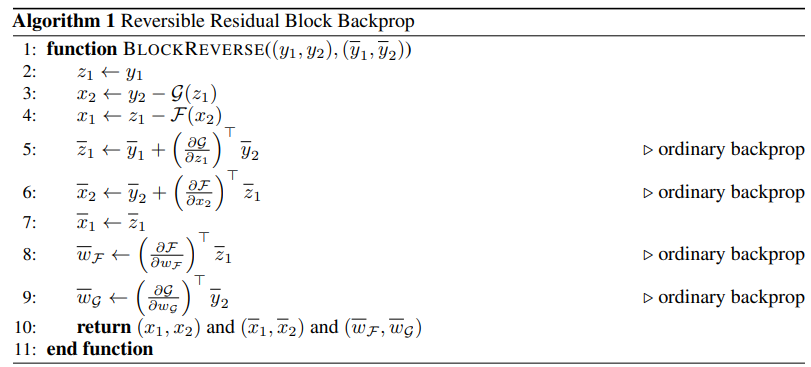

In [73]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0)

def cross_entropy(x, y):
    return -np.sum(y * np.log(x + 1e-10)) / len(y)

class ReVNet(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.hidden_connections = len(sizes) - 3
        input_size, hidden_size, output_size = (
            self.sizes[0],
            self.sizes[1],
            self.sizes[-1],
        )

        self.input_weights = np.random.randn(hidden_size, input_size)
        self.input_biases = np.random.randn(hidden_size, 1)

        self.function_size = hidden_size // 2
        self.F_weights = [
            np.random.randn(self.function_size, self.function_size)
            for _ in range(self.hidden_connections)
        ]
        self.G_weights = [
            np.random.randn(self.function_size, self.function_size)
            for _ in range(self.hidden_connections)
        ]
        self.F_biases = [
            np.random.randn(self.function_size, 1)
            for _ in range(self.hidden_connections)
        ]
        self.G_biases = [
            np.random.randn(self.function_size, 1)
            for _ in range(self.hidden_connections)
        ]

        self.output_weights = np.random.randn(output_size, hidden_size)
        self.output_biases = np.random.randn(output_size, 1)

    def feedforward(self, a):
        a = sigmoid(np.matmul(self.input_weights, a.T) + self.input_biases)
        x2, x1 = np.split(a, [self.function_size])
        for i in range(self.hidden_connections):
            x1 += sigmoid(np.matmul(self.F_weights[i], x2) + self.F_biases[i])
            x2 += sigmoid(np.matmul(self.G_weights[i], x1) + self.G_biases[i])

        return softmax(
            np.matmul(self.output_weights, np.concatenate((x2, x1), axis=0))
            + self.output_biases
        )

    def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
        biases_grad, weights_grad = self.backpropagation(x_mini_batch.T, y_mini_batch.T)
        factor = eta / len(x_mini_batch)

        self.input_weights -= factor * weights_grad[0]
        self.input_biases -= factor * biases_grad[0]
        self.output_weights -= factor * weights_grad[-1]
        self.output_biases -= factor * biases_grad[-1]

        for i in range(1, len(biases_grad) - 1):
            G_weights_grad, F_weights_grad = weights_grad[i]
            G_biases_grad, F_biases_grad = biases_grad[i]

            self.F_weights[i - 1] -= factor * F_weights_grad
            self.G_weights[i - 1] -= factor * G_weights_grad
            self.F_biases[i - 1] -= factor * F_biases_grad
            self.G_biases[i - 1] -= factor * G_biases_grad

    def backpropagation(self, x, y):
        a = sigmoid(np.matmul(self.input_weights, x) + self.input_biases)
        x2, x1 = np.split(a, [self.function_size])
        for i in range(self.hidden_connections):
            x1 += sigmoid(np.matmul(self.F_weights[i], x2) + self.F_biases[i])
            x2 += sigmoid(np.matmul(self.G_weights[i], x1) + self.G_biases[i])

        a = np.concatenate((x2, x1), axis=0)
        output = softmax(np.matmul(self.output_weights, a) + self.output_biases)
        dLdf = self.cost_derivative(output, y)
        dLdWs = [np.matmul(dLdf, a.T)]
        dLdBs = [np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1)]

        x2, x1 = np.split(a, [self.function_size])
        grad = np.matmul(self.output_weights.T, dLdf)
        x2_grad, x1_grad = np.split(grad, [self.function_size])

        for F_weights, F_biases, G_weights, G_biases in reversed(
            list(zip(self.F_weights, self.F_biases, self.G_weights, self.G_biases))
        ):
            z1 = x1
            x2 -= sigmoid(np.matmul(G_weights, x1) + G_biases)
            x1 -= sigmoid(np.matmul(F_weights, x2) + F_biases)

            G_prime = sigmoid_prime(np.matmul(G_weights, z1) + G_biases) * x2_grad
            x1_grad += np.matmul(G_prime.T, G_weights).T
            F_prime = sigmoid_prime(np.matmul(F_weights, x2) + F_biases) * x1_grad
            x2_grad += np.matmul(F_prime.T, F_weights).T

            dLdWs.append((np.matmul(G_prime, z1.T), np.matmul(F_prime, x2.T)))
            dLdBs.append(
                (
                    np.sum(G_prime, axis=1).reshape(G_prime.shape[0], 1),
                    np.sum(F_prime, axis=1).reshape(F_prime.shape[0], 1),
                )
            )

        in_layer_output = sigmoid(np.matmul(self.input_weights, x) + self.input_biases)
        dLdg = np.concatenate((x2_grad, x1_grad), axis=0)
        dLdf_input = dLdg * in_layer_output * (1 - in_layer_output)
        dLdWs.append(np.matmul(dLdf_input, x.T))
        dLdBs.append(np.sum(dLdf_input, axis=1).reshape(dLdg.shape[0], 1))

        return dLdBs[::-1], dLdWs[::-1]

    def cost_derivative(self, output_activations, y):
      return (output_activations-y)

    def evaluate(self, x_test_data, y_test_data):
        # Count the number of correct answers for test_data
          pred = np.argmax(self.feedforward(x_test_data),axis=0)
          corr = np.argmax(y_test_data,axis=1).T
          return np.mean(pred==corr)


    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                self.update_mini_batch(x_mini_batch, y_mini_batch, eta)

            train_accuracy = self.evaluate(x_train, y_train)
            logger.report_scalar(title='Accuracy', series='Train Accuracy', value=train_accuracy, iteration=j)
            if test_data:
                test_accuracy = self.evaluate(x_test, y_test)
                logger.report_scalar(title='Accuracy', series='Test Accuracy', value=test_accuracy, iteration=j)
                print("Epoch: {0}, Accuracy: {1}".format(j, test_accuracy))
            else:
                print("Epoch: {0}".format(j))

# Train the network

In [74]:
sizes = [784, 380, 380, 380, 10]
parameters = {"epochs": 50, "mini_batch_size": 100, "eta": 3.}

task.set_parameters({
    'sizes': sizes,
    'eta': parameters['eta'],
    'mini_batch_size': parameters['mini_batch_size'],
    'epochs': parameters['epochs']
})

model_RevNet = ReVNet(sizes)
model_RevNet.SGD((x_train, y_train), **parameters, test_data=(x_test, y_test))

logger.flush()
task.mark_completed()
task.close()

Epoch: 0, Accuracy: 0.8918
Epoch: 1, Accuracy: 0.9236
Epoch: 2, Accuracy: 0.9175
Epoch: 3, Accuracy: 0.9398
Epoch: 4, Accuracy: 0.9452
Epoch: 5, Accuracy: 0.9448
Epoch: 6, Accuracy: 0.9497
Epoch: 7, Accuracy: 0.9517
Epoch: 8, Accuracy: 0.953
Epoch: 9, Accuracy: 0.9523
Epoch: 10, Accuracy: 0.9535
Epoch: 11, Accuracy: 0.956
Epoch: 12, Accuracy: 0.9575
Epoch: 13, Accuracy: 0.9551
Epoch: 14, Accuracy: 0.9534
Epoch: 15, Accuracy: 0.9556
Epoch: 16, Accuracy: 0.9584
Epoch: 17, Accuracy: 0.9573
Epoch: 18, Accuracy: 0.9572
Epoch: 19, Accuracy: 0.9595
Epoch: 20, Accuracy: 0.9584
Epoch: 21, Accuracy: 0.9589
Epoch: 22, Accuracy: 0.9591
Epoch: 23, Accuracy: 0.9572
Epoch: 24, Accuracy: 0.9609
Epoch: 25, Accuracy: 0.9608
Epoch: 26, Accuracy: 0.9611
Epoch: 27, Accuracy: 0.9616
Epoch: 28, Accuracy: 0.9623
Epoch: 29, Accuracy: 0.9629
Epoch: 30, Accuracy: 0.9627
Epoch: 31, Accuracy: 0.9632
Epoch: 32, Accuracy: 0.9639
Epoch: 33, Accuracy: 0.9643
Epoch: 34, Accuracy: 0.9639
Epoch: 35, Accuracy: 0.964
Epoch

# Training plots for the best training

In [75]:
final_train_accuracy = model_RevNet.evaluate(x_train, y_train)
final_test_accuracy = model_RevNet.evaluate(x_test, y_test)
print(f"Final Train Accuracy: {final_train_accuracy}, Final Test Accuracy: {final_test_accuracy}")

Final Train Accuracy: 1.0, Final Test Accuracy: 0.9638


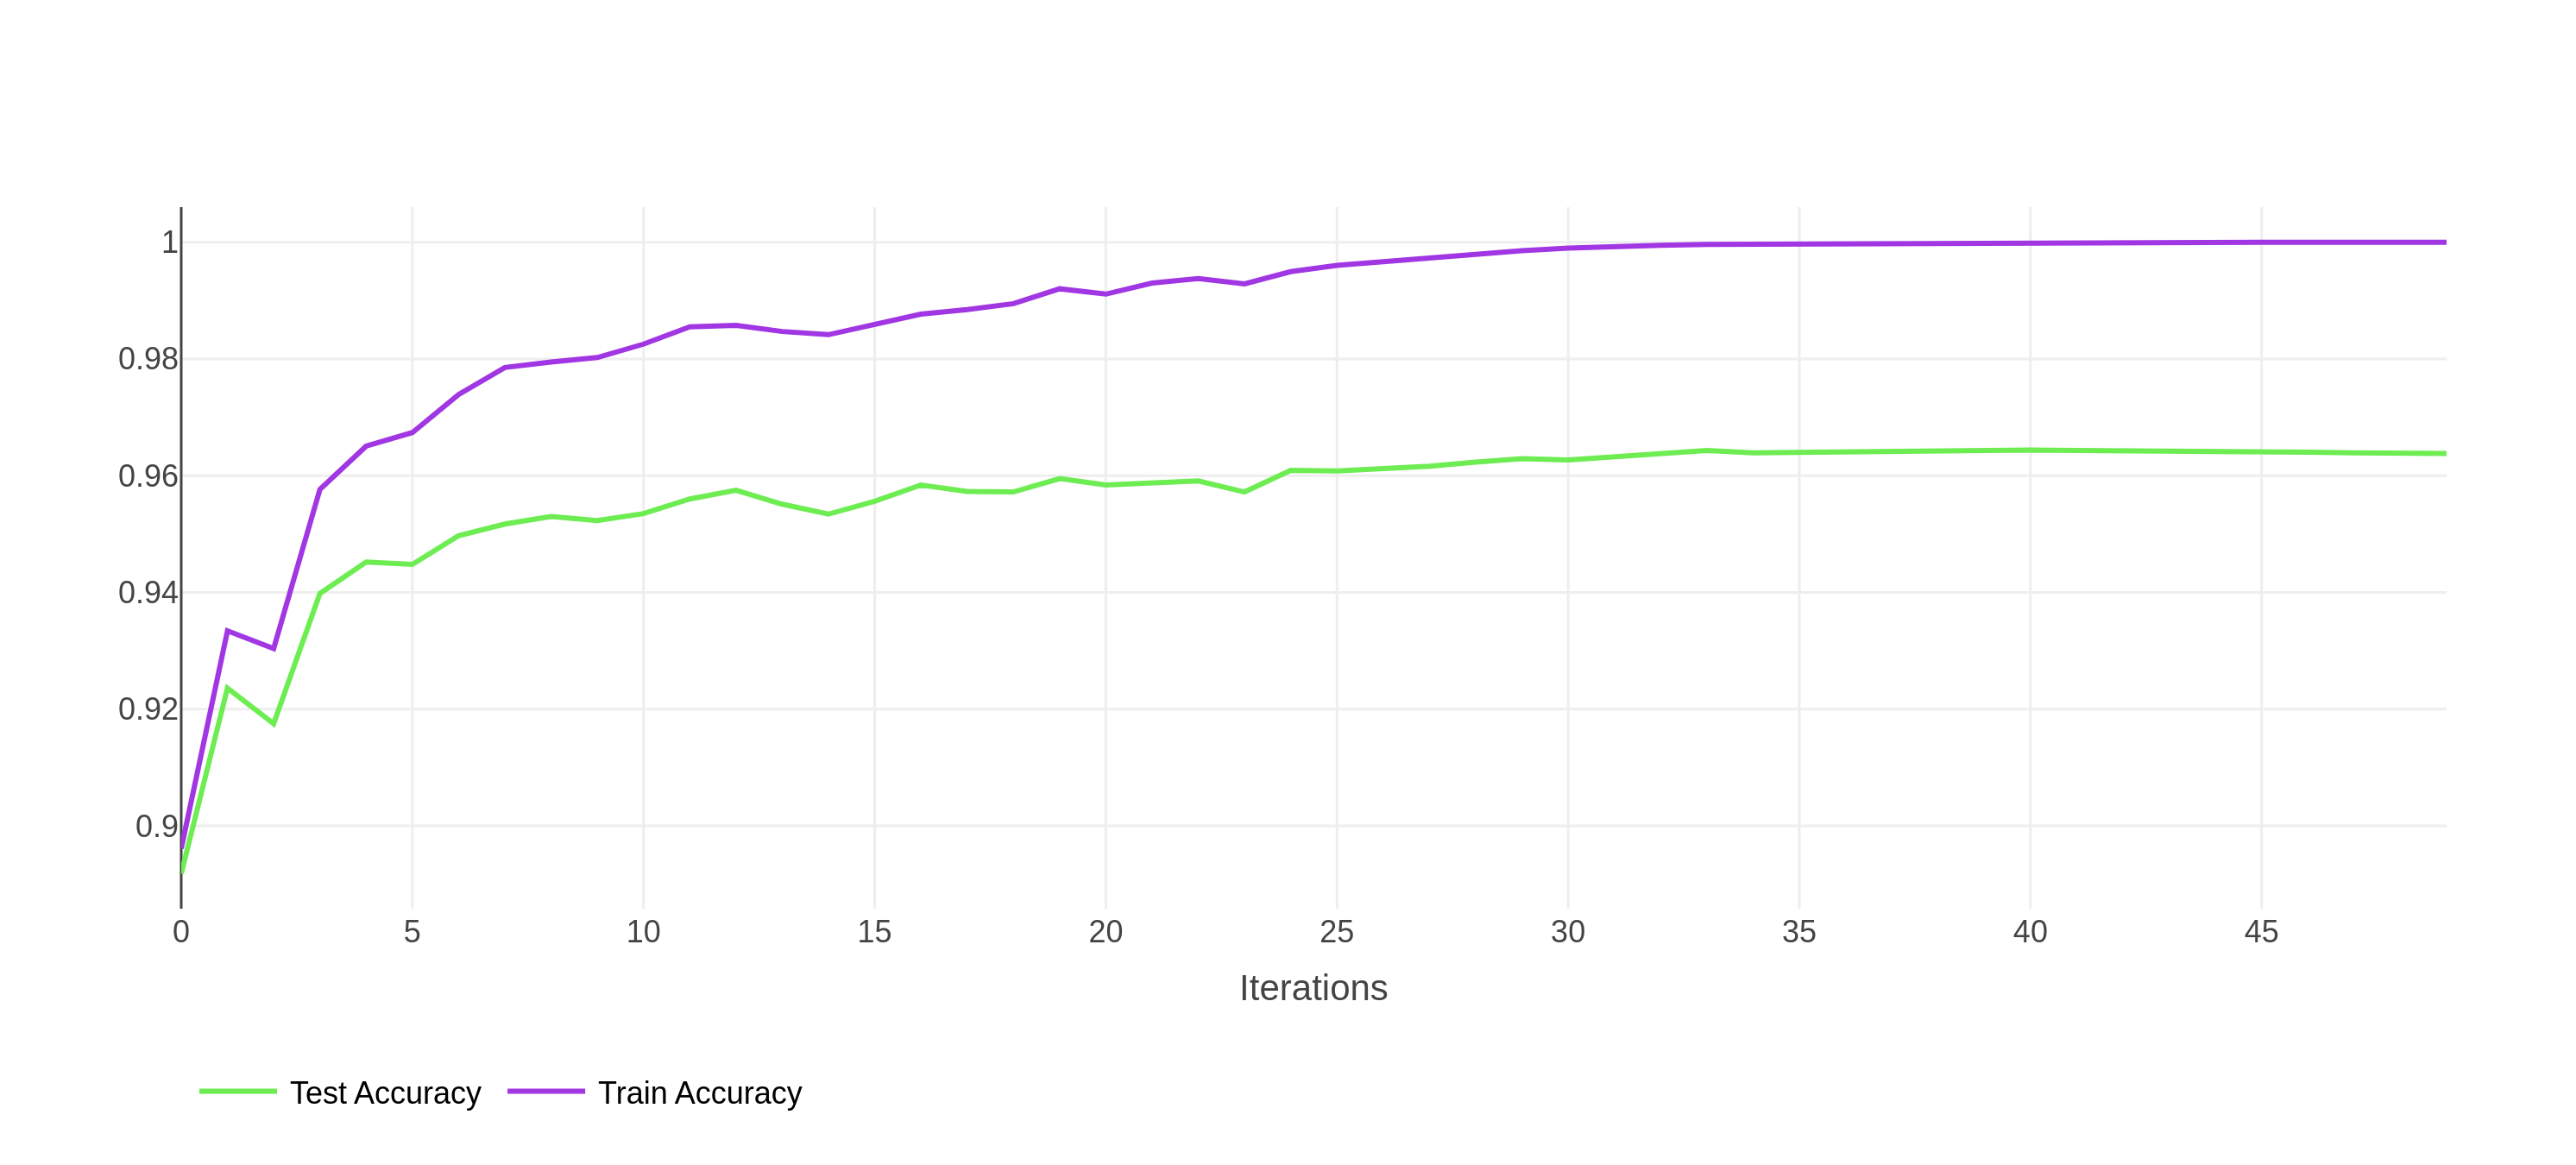

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [76]:
sizes = [784, 380, 380, 380, 10]
parameters = {"epochs": 20, "mini_batch_size": 100, "eta": 3.}

model_lab3 = Network(sizes)
model_RevNet = ReVNet(sizes)
for model, model_name in zip([model_lab3, model_RevNet], ['Model Lab3', 'Model RevNet']):
    print(f"Training {model_name}")
    %memit -r 1 model.SGD((x_train, y_train), **parameters, test_data=(x_test, y_test))

Training Model Lab3
Epoch: 0, Accuracy: 0.2342
Epoch: 1, Accuracy: 0.3094
Epoch: 2, Accuracy: 0.3497
Epoch: 3, Accuracy: 0.4539
Epoch: 4, Accuracy: 0.4653
Epoch: 5, Accuracy: 0.4714
Epoch: 6, Accuracy: 0.473
Epoch: 7, Accuracy: 0.4771
Epoch: 8, Accuracy: 0.4774
Epoch: 9, Accuracy: 0.4779
Epoch: 10, Accuracy: 0.4789
Epoch: 11, Accuracy: 0.479
Epoch: 12, Accuracy: 0.4803
Epoch: 13, Accuracy: 0.4808
Epoch: 14, Accuracy: 0.4805
Epoch: 15, Accuracy: 0.48
Epoch: 16, Accuracy: 0.4814
Epoch: 17, Accuracy: 0.482
Epoch: 18, Accuracy: 0.4822
Epoch: 19, Accuracy: 0.484
peak memory: 1928.47 MiB, increment: 108.45 MiB
Training Model RevNet
Epoch: 0, Accuracy: 0.9004
Epoch: 1, Accuracy: 0.9194
Epoch: 2, Accuracy: 0.92
Epoch: 3, Accuracy: 0.9287
Epoch: 4, Accuracy: 0.938
Epoch: 5, Accuracy: 0.9428
Epoch: 6, Accuracy: 0.9382
Epoch: 7, Accuracy: 0.937
Epoch: 8, Accuracy: 0.9505
Epoch: 9, Accuracy: 0.9294
Epoch: 10, Accuracy: 0.9304
Epoch: 11, Accuracy: 0.9318
Epoch: 12, Accuracy: 0.943
Epoch: 13, Accura